In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
import astropy.units as u
from astropy.coordinates import Distance
from astropy.cosmology import FlatLambdaCDM
from mcmc_tools import dolinmix_sep, split_data, plotFit_sep, plot_splitdata

rcp_orig = dict(matplotlib.rcParams)

matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.2
matplotlib.rcParams["xtick.major.size"] = 8.0
matplotlib.rcParams["ytick.major.size"] = 8.0
matplotlib.rcParams["xtick.minor.size"] = 3.0
matplotlib.rcParams["ytick.minor.size"] = 3.0
matplotlib.rcParams["xtick.minor.visible"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.minor.visible"] = True
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True

In [2]:
# master = pd.read_csv('data/master_v3.csv')
master = pd.read_csv('data/master_v3.1.csv')
master = master[np.abs(master.vel) < 99]
master = master[master.vel < -6]

In [3]:
master_x1 = master[~np.isnan(master.x1_snana)]
master_c = master[~np.isnan(master.c_snana)]

In [4]:
massvel_werr = pd.read_csv('data/mass_vel_data_expanded_v1.1.dat')
massvel_werr = massvel_werr[(~np.isnan(massvel_werr.mass)) & (~np.isnan(massvel_werr.vel))]
# Removing objects with velocities 99 and -99 as they were classified as high velocity or normal by Wang09 but
# do not have a measured velocity
massvel_werr = massvel_werr[np.abs(massvel_werr.vel) < 99]
# Removing ASASSN-15mi because it is IaPec
massvel_werr = massvel_werr[massvel_werr.Name != 'asassn-15mi']
# Removing 2007a because of its high velocity uncertainty
# massvel_werr = massvel_werr[massvel_werr.Name != '2007a']
# Removing 1997e because of high mass uncertainty
massvel_werr = massvel_werr[massvel_werr.Name != '1997e']
massvel_werr.loc[massvel_werr['mass'] < 7.0,'masserr'] = 0.0
# Those objects with mass = 5.0 are placeholder values, for the sake of asthetics and because their
# actual mass is low, but essentially unknown, we will set their value higher
massvel_werr.loc[massvel_werr['mass'] == 5.0,'mass'] = 7.0

In [5]:
master_snana = master[(~np.isnan(master.x1_snana)) & (~np.isnan(master.c_snana))]
master_snana.rename(columns={'c_snana':'c','c_err_snana':'c_err','x1_snana':'x1','x1_err_snana':'x1_err'},
                    inplace=True)
master_mass_snana = pd.merge(master_snana[['Name','c','c_err','x1','x1_err','vel','vel_err','foundation','csp','w09','z']],
                             massvel_werr[['Name','mass','masserr','symbol']],on='Name')
master_mass_snana.head()

/Users/dettman/opt/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Name,c,c_err,x1,x1_err,vel,vel_err,foundation,csp,w09,z,mass,masserr,symbol
0,2004dt,-0.040976,0.024533,-0.304240,0.029906,-13.922216,0.225133,False,True,True,0.019720,10.554400,0.158451,o
1,2004ef,0.087047,0.021103,-1.398890,0.022198,-12.038555,0.248283,False,True,True,0.030970,10.896400,0.144271,o
2,2004eo,0.004750,0.021584,-1.222000,0.020308,-10.260561,0.237697,False,True,True,0.014747,11.093467,0.144571,o
3,2004ey,-0.130556,0.020361,0.080067,0.018008,-10.999163,0.278029,False,True,True,0.015780,10.005533,0.140080,o
4,2004gc,0.092027,0.023207,-0.638214,0.035156,-10.471784,0.228035,False,True,False,0.032080,10.433200,0.158451,o


In [6]:
def histPlot_mass(data,csp_color='#d40a0c',found_color='#074ede',w09_color='#d95f02',
                  x1lim = [-3.5,3.7],clim = [-0.3,1.1],vellim = [-7,-18.5],masslim = [6.5,12.25]):
    fig, ax = plt.subplots(3,3,figsize=(24,20),gridspec_kw={'width_ratios':[3.5,3.5,1],'height_ratios':[1,3,3]})
    plt.subplots_adjust(hspace=0.0,wspace=0.0)
    fig.delaxes(ax[0,2])

    ax[0,0].set_xticklabels([])
    ax[0,0].set_yticklabels([])
    ax[0,1].set_xticklabels([])
    ax[0,1].set_yticklabels([])
    ax[1,0].set_xticklabels([])
    ax[1,1].set_xticklabels([])
    ax[1,2].set_xticklabels([])
    ax[1,2].set_yticklabels([])
    ax[1,1].set_yticklabels([])
    ax[2,1].set_yticklabels([])
    ax[2,2].set_xticklabels([])
    ax[2,2].set_yticklabels([])
    ax[0,0].set_xticks([])
    ax[0,0].set_yticks([])
    ax[0,1].set_xticks([])
    ax[0,1].set_yticks([])
    ax[1,2].set_xticks([])
    ax[1,2].set_yticks([])
    ax[2,2].set_yticks([])
    ax[2,2].set_xticks([])
    
    malpha = 0.6
    histalpha = 0.3
    mrksize = 8.0
    
    # x1 data
    ax[1,0].errorbar(data[data.csp==True].x1,data[data.csp==True].vel,
                     xerr=data[data.csp==True].x1_err,yerr=data[data.csp==True].vel_err,
                     color=csp_color,ecolor=csp_color,linestyle='',marker='X',alpha=malpha,label='CSP')
    ax[1,0].errorbar(data[data.w09==True].x1,data[data.w09==True].vel,
                     xerr=data[data.w09==True].x1_err,yerr=data[data.w09==True].vel_err,
                     color=w09_color,ecolor=w09_color,linestyle='',marker='P',alpha=malpha,label='W09/FK11')
    ax[1,0].errorbar(data[(data.foundation==True)].x1,
                     data[(data.foundation==True)].vel,
                     xerr=data[(data.foundation==True)].x1_err,
                     yerr=data[(data.foundation==True)].vel_err,
                     color=found_color,ecolor=found_color,linestyle='',marker='o',alpha=malpha,label='Foundation')
    ax[1,0].plot([-10,10],[-11.8,-11.8],':',color='forestgreen',alpha=0.8)
    
    ax[2,0].errorbar(data[data.csp==True].x1,data[data.csp==True].mass,
                     xerr=data[data.csp==True].x1_err,yerr=data[data.csp==True].masserr,
                     color=csp_color,ecolor=csp_color,linestyle='',marker='X',alpha=malpha,label='CSP')
    ax[2,0].errorbar(data[data.w09==True].x1,data[data.w09==True].mass,
                     xerr=data[data.w09==True].x1_err,yerr=data[data.w09==True].masserr,
                     color=w09_color,ecolor=w09_color,linestyle='',marker='P',alpha=malpha,label='W09/FK11')
    ax[2,0].errorbar(data[(data.foundation==True) & (data.mass>7.0)].x1,
                     data[(data.foundation==True) & (data.mass>7.0)].mass,
                     xerr=data[(data.foundation==True) & (data.mass>7.0)].x1_err,
                     yerr=data[(data.foundation==True) & (data.mass>7.0)].masserr,
                     color=found_color,ecolor=found_color,linestyle='',marker='o',alpha=malpha,label='Foundation')
    
    ax[2,0].plot(data[(data.foundation==True) & (data.mass<=7.0)].x1,
                 data[(data.foundation==True) & (data.mass<=7.0)].mass,
                 color=found_color,linestyle='',marker='v',alpha=malpha)
    ax[2,0].errorbar(data[(data.foundation==True) & (data.mass<=7.0)].x1,
                     data[(data.foundation==True) & (data.mass<=7.0)].mass+0.029,
                     xerr=data[(data.foundation==True) & (data.mass<=7.0)].x1_err,
                     yerr=data[(data.foundation==True) & (data.mass<=7.0)].masserr,
                     color=found_color,ecolor=found_color,linestyle='',marker='',alpha=malpha)
    
    x1bins = np.linspace(-4.0,4.0,21)
    ax[0,0].hist(data[data.csp==True].x1,bins=x1bins,color=csp_color,hatch='/',alpha=histalpha,
                 density=True,label='CSP')
    ax[0,0].hist(data[data.w09==True].x1,bins=x1bins,color=w09_color,hatch='\\',alpha=histalpha,
                 density=True,label='W09/FK11')
    ax[0,0].hist(data[data.foundation==True].x1,bins=x1bins,color=found_color,hatch='|',alpha=histalpha,
                 density=True,label='Foundation')
    
    # c data
    ax[1,1].errorbar(data[data.csp==True].c,data[data.csp==True].vel,
                     xerr=data[data.csp==True].c_err,yerr=data[data.csp==True].vel_err,
                     color=csp_color,ecolor=csp_color,linestyle='',marker='X',alpha=malpha,label='CSP')
    ax[1,1].errorbar(data[data.w09==True].c,data[data.w09==True].vel,
                     xerr=data[data.w09==True].c_err,yerr=data[data.w09==True].vel_err,
                     color=w09_color,ecolor=w09_color,linestyle='',marker='P',alpha=malpha,label='W09/FK11')
    ax[1,1].errorbar(data[(data.foundation==True)].c,
                     data[(data.foundation==True)].vel,
                     xerr=data[(data.foundation==True)].c_err,
                     yerr=data[(data.foundation==True)].vel_err,
                     color=found_color,ecolor=found_color,linestyle='',marker='o',alpha=malpha,label='Foundation')
    ax[1,1].plot([-10,10],[-11.8,-11.8],':',color='forestgreen',alpha=0.8)
#     ax[1,1].legend(fontsize=28, frameon=False, handletextpad=0.3, loc='upper right')
    
    ax[2,1].errorbar(data[data.csp==True].c,data[data.csp==True].mass,
                     xerr=data[data.csp==True].c_err,yerr=data[data.csp==True].masserr,
                     color=csp_color,ecolor=csp_color,linestyle='',marker='X',alpha=malpha,label='CSP')
    ax[2,1].errorbar(data[data.w09==True].c,data[data.w09==True].mass,
                     xerr=data[data.w09==True].c_err,yerr=data[data.w09==True].masserr,
                     color=w09_color,ecolor=w09_color,linestyle='',marker='P',alpha=malpha,label='W09/FK11')
    ax[2,1].errorbar(data[(data.foundation==True) & (data.mass>7.0)].c,
                     data[(data.foundation==True) & (data.mass>7.0)].mass,
                     xerr=data[(data.foundation==True) & (data.mass>7.0)].c_err,
                     yerr=data[(data.foundation==True) & (data.mass>7.0)].masserr,
                     color=found_color,ecolor=found_color,linestyle='',marker='o',alpha=malpha,label='Foundation')
    
    ax[2,1].plot(data[(data.foundation==True) & (data.mass<=7.0)].c,
                 data[(data.foundation==True) & (data.mass<=7.0)].mass,
                 color=found_color,linestyle='',marker='v',alpha=malpha)
    ax[2,1].errorbar(data[(data.foundation==True) & (data.mass<=7.0)].c,
                     data[(data.foundation==True) & (data.mass<=7.0)].mass+0.029,
                     xerr=data[(data.foundation==True) & (data.mass<=7.0)].c_err,
                     yerr=data[(data.foundation==True) & (data.mass<=7.0)].masserr,
                     color=found_color,ecolor=found_color,linestyle='',marker='',alpha=malpha)
    ax[1,1].plot([-10,10],[-11.8,-11.8],':',color='forestgreen',alpha=0.8)
    
#     cbins = np.linspace(-0.4,1.4,46)
    cbins = np.linspace(-0.375,1.125,25)
    ax[0,1].hist(data[data.csp==True].c,bins=cbins,color=csp_color,hatch='/',alpha=histalpha,
                 density=True,label='CSP')
    ax[0,1].hist(data[data.w09==True].c,bins=cbins,color=w09_color,hatch='\\',alpha=histalpha,
                 density=True,label='W09/FK11')
    ax[0,1].hist(data[data.foundation==True].c,bins=cbins,color=found_color,hatch='|',alpha=histalpha,
                 density=True,label='Foundation')
    
    # vel hists
    velbins = np.linspace(-18.5,-7,24)
    ax[1,2].hist(data[data.csp==True].vel,bins=velbins,color=csp_color,hatch='/',alpha=histalpha,
                 density=True,orientation='horizontal',label='CSP')
    ax[1,2].hist(data[data.w09==True].vel,bins=velbins,color=w09_color,hatch='\\',alpha=histalpha,
                 density=True,orientation='horizontal',label='W09/FK11')
    ax[1,2].hist(data[data.foundation==True].vel,bins=velbins,color=found_color,hatch='|',alpha=histalpha,
                 density=True,orientation='horizontal',label='Foundation')
    
    # mass hists
    massbins = np.linspace(4.75,12.25,31)
    ax[2,2].hist(data[data.csp==True].mass,bins=massbins,color=csp_color,hatch='/',alpha=histalpha,
                 density=True,orientation='horizontal',label='CSP')
    ax[2,2].hist(data[data.w09==True].mass,bins=massbins,color=w09_color,hatch='\\',alpha=histalpha,
                 density=True,orientation='horizontal',label='W09/FK11')
    ax[2,2].hist(data[data.foundation==True].mass,bins=massbins,color=found_color,hatch='|',alpha=histalpha,
                 density=True,orientation='horizontal',label='Foundation')
    
    # adding "cut" regions
    ylim_x1hist = ax[0,0].get_ylim()
    ylim_chist = ax[0,1].get_ylim()
    ax[0,1].fill_between([0.3,10],[0,0],[100,100],color='lightgrey',alpha=0.5)
    ax[0,1].fill_between([-0.3,-10],[0,0],[100,100],color='lightgrey',alpha=0.5)
    ax[1,1].fill_between([0.3,10],[-20,-20],[0,0],color='lightgrey',alpha=0.5)
    ax[1,1].fill_between([-0.3,-10],[-20,-20],[0,0],color='lightgrey',alpha=0.5)
    ax[2,1].fill_between([0.3,10],[0,0],[20,20],color='lightgrey',alpha=0.5)
    ax[2,1].fill_between([-0.3,-10],[0,0],[20,20],color='lightgrey',alpha=0.5)
    
    ax[0,0].fill_between([3,100],[0,0],[1,1],color='lightgrey',alpha=0.5)
    ax[0,0].fill_between([-3,-100],[0,0],[1,1],color='lightgrey',alpha=0.5)
    ax[1,0].fill_between([3,100],[-20,-20],[0,0],color='lightgrey',alpha=0.5)
    ax[1,0].fill_between([-3,-100],[-20,-20],[0,0],color='lightgrey',alpha=0.5)
    ax[2,0].fill_between([3,100],[0,0],[20,20],color='lightgrey',alpha=0.5)
    ax[2,0].fill_between([-3,-100],[0,0],[20,20],color='lightgrey',alpha=0.5)
    
    ax[1,0].set_xlim(x1lim)
    ax[0,0].set_xlim(x1lim)
    ax[2,0].set_xlim(x1lim)
    
    ax[1,1].set_xlim(clim)
    ax[0,1].set_xlim(clim)
    ax[2,1].set_xlim(clim)
    
    ax[1,0].set_ylim(vellim)
    ax[1,1].set_ylim(vellim)
    ax[1,2].set_ylim(vellim)
    
    ax[2,0].set_ylim(masslim)
    ax[2,1].set_ylim(masslim)
    ax[2,2].set_ylim(masslim)
    
    ax[0,0].set_ylim(ylim_x1hist)
    ax[0,1].set_ylim(ylim_chist)
    
    ax[1,0].tick_params(labelsize=28)
    ax[1,1].tick_params(labelsize=28)
    ax[2,1].tick_params(labelsize=28)
    ax[2,0].tick_params(labelsize=28)
    
    ax[2,0].set_xlabel(r'SALT2 $x_1$', fontsize=36)
    ax[2,0].set_ylabel(r'Host galaxy stellar mass, $\log(M_\star/M_\odot)$',fontsize=32)
    ax[1,0].set_ylabel('Si II velocity [1000 km/s]', fontsize=34)
    ax[2,1].set_xlabel(r'SALT2 $c$', fontsize=36)
    
    legend_elements = [(Line2D([0], [0], marker='X',linestyle='',color=csp_color,label='CSP',markersize=12,
                              alpha=malpha),
                       Patch(facecolor=csp_color,label='CSP',hatch='/',alpha=histalpha)),
                       (Line2D([0], [0], marker='P',linestyle='',color=w09_color,label='W09',markersize=12,
                              alpha=malpha),
                       Patch(facecolor=w09_color,label='W09',hatch='\\',alpha=histalpha)),
                       (Line2D([0], [0], marker='o',linestyle='',color=found_color,label='Foundation',
                              markersize=12,alpha=malpha),
                       Patch(facecolor=found_color,label='Foundation',hatch='|',alpha=histalpha))]
    ax[1,1].legend(legend_elements, 
                   ['CSP ({})'.format(len(data[data.csp==True])),
                    'W09/FK11 ({})'.format(len(data[data.w09==True])),
                    'Foundation ({})'.format(len(data[data.foundation==True]))],
                   numpoints=1,
                   handler_map={tuple: HandlerTuple(ndivide=None)},
                   fontsize=28, frameon=False, bbox_to_anchor=(0.95, 0.69), handletextpad=0.3, loc='lower right')

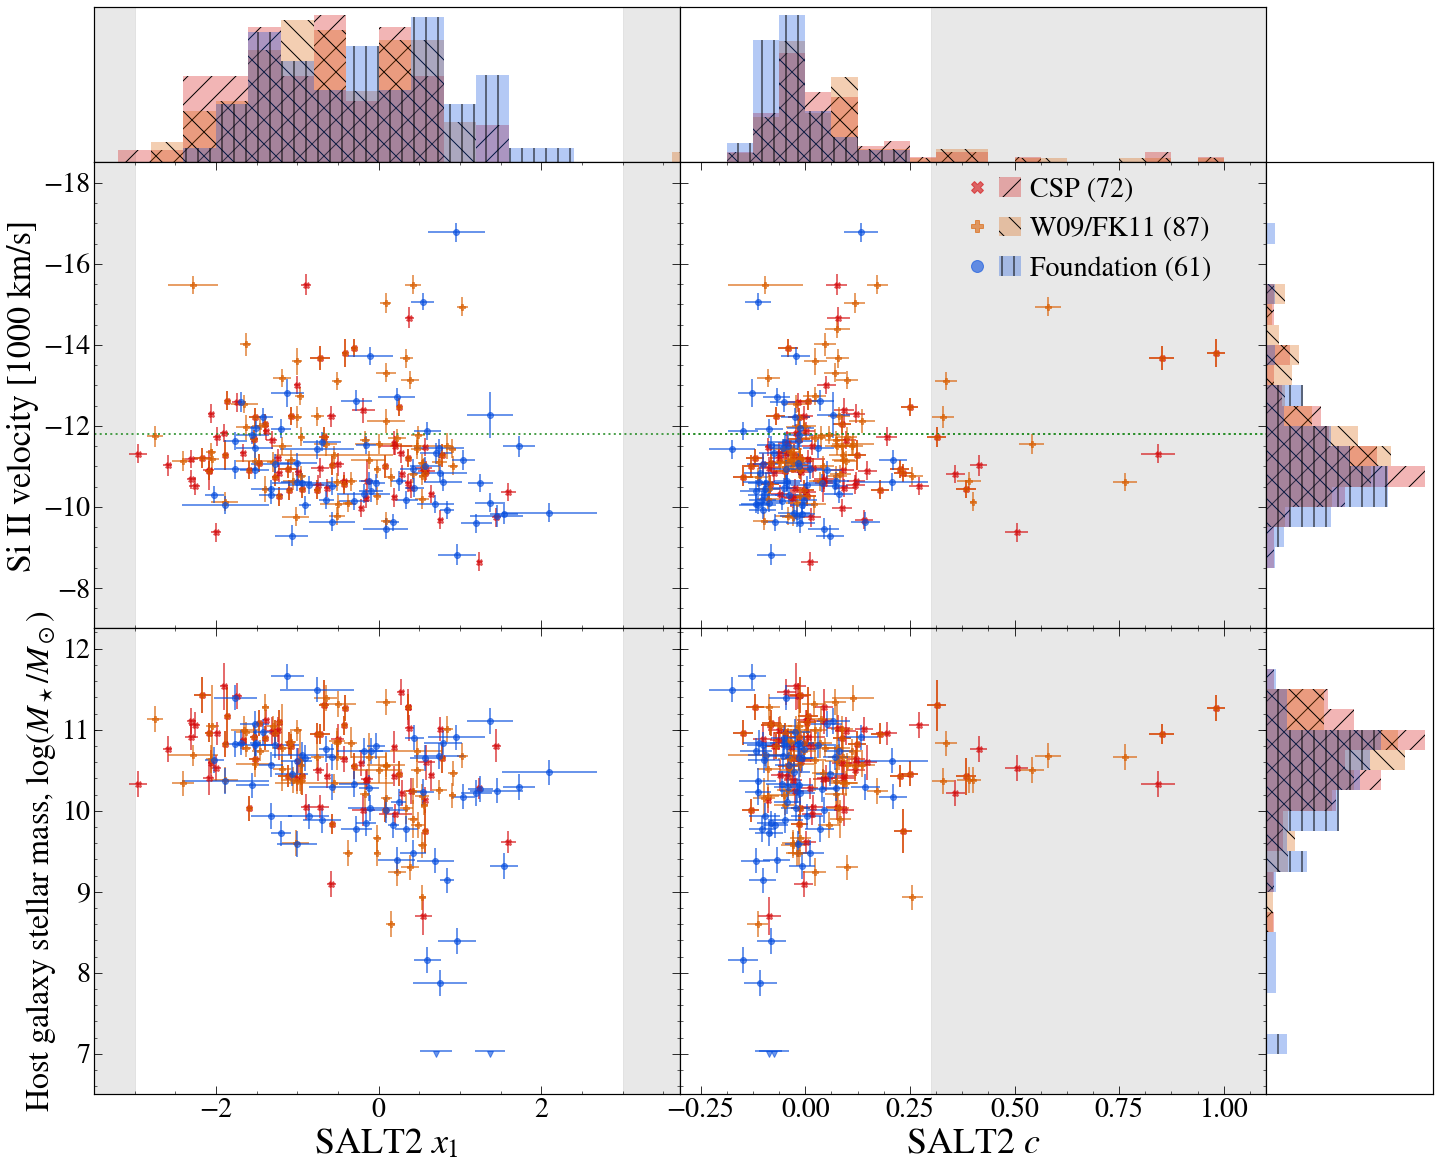

In [28]:
histPlot_mass(master_mass_snana)
plt.savefig('x1_c_figures/x1_c_vel_mass_full.pdf',bbox_inches='tight')
plt.savefig('x1_c_figures/x1_c_vel_mass_full.png',bbox_inches='tight',dpi=600,transparent=True)
plt.savefig('x1_c_figures/x1_c_vel_mass_full_lowres.png',bbox_inches='tight',dpi=200,transparent=True)

In [9]:
from scipy.stats import anderson_ksamp

def adplot(sample1, sample2, label1='', label2='', xlabel=r'Host Stellar Mass log($M_*/M_\odot$)'):
    result = anderson_ksamp([sample1,sample2])
    label1N = label1 + '; N = {0:d}'.format(len(sample1))
    label2N = label2 + '; N = {0:d}'.format(len(sample2))
    plt.hist([sample1,sample2],histtype='stepfilled',density=True,
             alpha=0.4,color=['r','b'],label=[label1N,label2N])
    plt.xlabel(xlabel)
    plt.title('A-D significance level = {0:5.3f}'.format(result.significance_level))
    plt.legend(loc='upper left')
    return result

In [10]:
print('Foundation median vel: {:.2f}'.format(np.median(master[(master.foundation == True)].vel)))
print('W09/FK11 median vel: {:.2f}'.format(np.median(master[(master.w09 == True)].vel)))
print('CSP median vel: {:.2f}'.format(np.median(master[(master.csp == True)].vel)))

Foundation median vel: -10.74
W09/FK11 median vel: -11.16
CSP median vel: -10.95


Anderson_ksampResult(statistic=1.3003211787316775, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.0946074875706893)

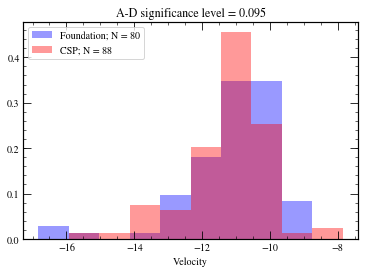

In [11]:
adplot(master[(master.csp == True)].vel, master[(master.foundation == True)].vel, 
       label1='CSP',label2='Foundation',xlabel='Velocity')

/Users/dettman/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: p-value floored: true value smaller than 0.001
  after removing the cwd from sys.path.


Anderson_ksampResult(statistic=7.233927531168719, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

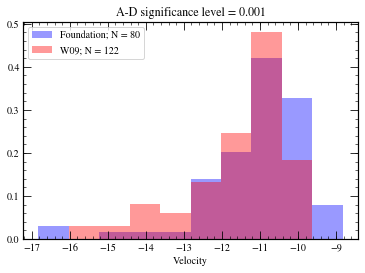

In [12]:
adplot(master[(master.w09 == True)].vel, master[(master.foundation == True)].vel, 
       label1='W09',label2='Foundation',xlabel='Velocity')

Anderson_ksampResult(statistic=1.0922049123772806, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.11564252018108306)

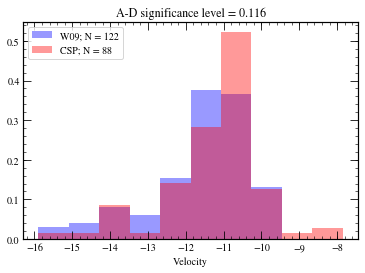

In [13]:
adplot(master[(master.csp == True)].vel, master[(master.w09 == True)].vel, 
       label1='CSP',label2='W09',xlabel='Velocity')

/Users/dettman/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: p-value capped: true value larger than 0.25
  after removing the cwd from sys.path.


Anderson_ksampResult(statistic=-0.7365239024429101, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)

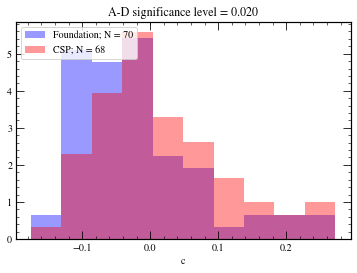

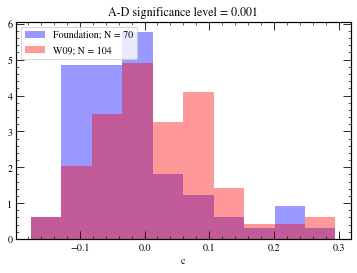

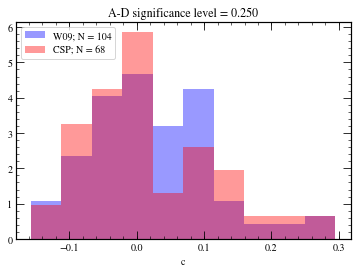

In [14]:
adplot(master[(master.csp == True)&(master.c_snana < 0.3)].c_snana, 
       master[(master.foundation == True)&(master.c_snana < 0.3)].c_snana, 
       label1='CSP',label2='Foundation',xlabel='c')
plt.figure()
adplot(master[(master.w09 == True)&(master.c_snana < 0.3)].c_snana, 
       master[(master.foundation == True)&(master.c_snana < 0.3)].c_snana, 
       label1='W09',label2='Foundation',xlabel='c')
plt.figure()
adplot(master[(master.csp == True)&(master.c_snana < 0.3)].c_snana, 
       master[(master.w09 == True)&(master.c_snana < 0.3)].c_snana, 
       label1='CSP',label2='W09',xlabel='c')

In [15]:
from cuts import cosmo_cuts
found_ana = master[master.foundation == True][['Name','z','vel','vel_err','c_snana','c_err_snana','x0_snana',
                                               'x0_err_snana','x1_snana','x1_err_snana']]
found_ana.rename(columns={'c_snana':'c','c_err_snana':'c_err','x0_snana':'x0','x0_err_snana':'x0_err',
                          'x1_snana':'x1','x1_err_snana':'x1_err'},inplace=True)
csp_ana = master[master.csp == True][['Name','z','vel','vel_err','c_snana','c_err_snana','x0_snana',
                                               'x0_err_snana','x1_snana','x1_err_snana']]
csp_ana.rename(columns={'c_snana':'c','c_err_snana':'c_err','x0_snana':'x0','x0_err_snana':'x0_err',
                          'x1_snana':'x1','x1_err_snana':'x1_err'},inplace=True)
w09_ana = master[master.w09 == True][['Name','z','vel','vel_err','c_snana','c_err_snana','x0_snana',
                                         'x0_err_snana','x1_snana','x1_err_snana']]
w09_ana.rename(columns={'c_snana':'c','c_err_snana':'c_err','x0_snana':'x0','x0_err_snana':'x0_err',
                           'x1_snana':'x1','x1_err_snana':'x1_err'},inplace=True)

found_ana = cosmo_cuts(found_ana)
csp_ana = cosmo_cuts(csp_ana)
w09_ana = cosmo_cuts(w09_ana)

Median z (Foundation):0.038
Median z (CSP):0.025
Median z (W09/FK11):0.021


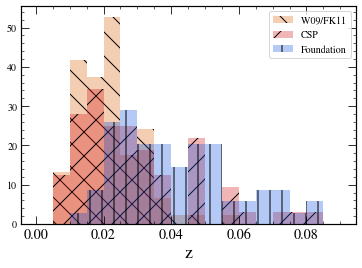

In [26]:
zbins = np.linspace(0,0.09,19)
plt.hist(w09_ana.z,bins=zbins,color='#d95f02',hatch='\\',alpha=0.3,label='W09/FK11',density=True)
plt.hist(csp_ana.z,bins=zbins,color='#d40a0c',hatch='/',alpha=0.3,label='CSP',density=True)
plt.hist(found_ana.z,bins=zbins,color='#074ede',hatch='|',alpha=0.3,label='Foundation',density=True)
plt.xlabel('z',size=18)
plt.xticks(size=16)
plt.xticks(size=14)
plt.legend()
print('Median z (Foundation):{:.3f}'.format(np.median(found_ana.z)))
print('Median z (CSP):{:.3f}'.format(np.median(csp_ana.z)))
print('Median z (W09/FK11):{:.3f}'.format(np.median(w09_ana.z)))
plt.savefig('x1_c_figures/z_dist_ref.pdf',bbox_inches='tight')
plt.savefig('x1_c_figures/z_dist_ref.png',bbox_inches='tight',dpi=600)